## Experiments with _Water meters_!
In this notebook we will train ResNet101, DenseNet121 and VGG19 to predict numbers on water meter.

In [ ]:
!nvidia-smi

Fri Feb 09 11:31:06 2018       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 384.94                 Driver Version: 384.94                    |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  GeForce GTX 1050   WDDM  | 00000000:01:00.0 Off |                  N/A |
| N/A   37C    P8    N/A /  N/A |     77MiB /  4096MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [ ]:
import sys
import os

import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook as tqn
%matplotlib inline

sys.path.append('..\..')

import meters as ms
from meters.batch import MeterBatch
from meters.dataset import B,V,F, FilesIndex, Dataset, Pipeline
from meters.dataset.dataset.models.tf import ResNet18, DenseNet121, VGG19
from detection_model import NearestDetection

plt.style.use('seaborn-poster')
plt.style.use('ggplot')

Create fileindex witch allows us to loading only part of images instead all images.

`src` - the path to images in blosc format.

In [ ]:
# tmp = (
#     Pipeline()
#     .load(src=src, fmt='blosc', components='images')
#     .load(src='labels/data.csv',\
#           fmt='csv',\
#           components=['coordinates', 'labels'],\
#           index_col='file_name') << dset.train)
# btch = tmp.next_batch(10)

In [ ]:
src = 'images/'

fileindex = FilesIndex(path=src+'*.blosc', no_ext=True)

dset = Dataset(fileindex, batch_class=MeterBatch)
dset.cv_split()

Write pipeline to load and crop data and labels

In [ ]:
BATCH_SIZE = 25
NUM_DIGITS = 8
HEIGHT = 32
WIDTH = 16
NEW_SIZE = (HEIGHT, int(np.round(WIDTH * NUM_DIGITS * 1.5)), 3)

In [ ]:
NEW_SIZE

In [ ]:
load_ppl = (
    Pipeline()
    .load(src=src, fmt='blosc', components='images')
    .load(src='labels/data.csv',\
          fmt='csv',\
          components=['coordinates', 'labels'],\
          index_col='file_name')
    .crop_from_bbox()
    .crop_background(new_size=NEW_SIZE)
    .split_labels()
    .split_to_digits(n_digits=8)
    .resize(shape=(HEIGHT, WIDTH))
    .one_hot()
    .generate_data(n_digits=NUM_DIGITS, normalize=True)
)

With config create model parameters 

In [ ]:
# inputs_config = {
#     'images': {'shape': NEW_SIZE},
#     'labels': {'classes': (10), 'transform': 'ohe', 'name': 'targets'}
# }

# config = {
#     'inputs': inputs_config,
#     'optimizer': 'Adam',
#     'loss': 'ce',
#     'input_block/inputs': 'images',
#     'head/units': [10],
#     'output': dict(ops=['labels', 'proba', 'accuracy'])
# }

In [ ]:
placeholders_config = {'images': {'shape': NEW_SIZE,
                                  'name': 'reshaped_images'},
                       'labels': {
                                  'shape': (NUM_DIGITS * 10),
                                  'name': 'targets'},
                       'coordinates': {'shape': (NUM_DIGITS, 4)},
                      }
                       
config={'inputs': placeholders_config,
        'input_block/inputs': 'images',
        'loss': None,
        'num_digits': NUM_DIGITS,
        'output': dict(ops=['labels', 'proba', 'accuracy'])
}


saved_fetches=[V('loss'),
               B('predicted_bb')]

fetches_list=['loss', 'NearestDetection/predicted_bb']

saved_feed_dict={'images': B('images'),
                 'labels': B('labels'),
                 'coordinates': B('coordinates'),
                }
#         'optimizer':  {'name': 'Momentum', 'momentum': 0.5, 'learning_rate': 0.1}}

We will experements with models. For this create dict with:
* `key` - model
* `value` - model name

In [ ]:
models = [NearestDetection]
models_names = ['NearestDetection']
models_dict = dict(zip(models_names, models))

In [ ]:
def get_ppl(model, name):
    """"Create train and test pipeline using given `model` and `name`
    
    Parameters
    ----------
    model : Dataset model
        preloaded model from dataset
    
    name : str
        name of model
    
    Returns
    -------
    train_ppl : Dataset pipeline
        train pipeline

    test_ppl : Dataset pipeline
        test pipeline"""
    train_ppl = (
        (load_ppl << dset.train)
        .init_variable('model', model)
        .init_variable('loss', init_on_each_run=list)
        .init_model('dynamic',
                    V('model'),
                    name,
                    config=config)
        .train_model(name,
                     fetches=fetches_list,
                     feed_dict=saved_feed_dict,
                     save_to=saved_fetches, 
                     mode='a')
    )

    test_ppl = (
        (load_ppl << dset.test)
        .init_variable('loss', init_on_each_run=list)
        .init_variable('proba', init_on_each_run=list)
        .init_variable('target', init_on_each_run=list)
        .init_variable('accuracy', init_on_each_run=list)
        .import_model(name, train_ppl)
        .predict_model(name,
                       fetches=fetches_list,
                       feed_dict=saved_feed_dict,
                       save_to=saved_fetches, 
                       mode='a')
    )
    pred_ppl = (
    (load_ppl << dset.test)
    .init_variable('loss', init_on_each_run=list)
    .import_model(name, train_ppl)
    .predict_model(name,
                   fetches=fetches_list,
                   feed_dict=saved_feed_dict,
                   save_to=saved_fetches, 
                   mode='a')
    )
    return train_ppl, test_ppl

train pipelines with different models and save it after training

In [ ]:
models_dict.items()

In [ ]:
NUM_ITERS = 1

In [ ]:
global_acc = []
for name, model in models_dict.items():
    print(name)
    train_ppl, test_ppl = get_ppl(model, name)
#     for i in tqn(range(NUM_ITERS)):
#         tr = train_ppl.next_batch(BATCH_SIZE, n_epochs=None, suffle=True, drop_last=True)
#         te = test_ppl.next_batch(BATCH_SIZE, n_epochs=None, suffle=True, drop_last=True)

In [ ]:
test_ppl = (
    (load_ppl << dset.test)
    .init_variable('loss', init_on_each_run=list)
    .init_variable('proba', init_on_each_run=list)
    .init_variable('target', init_on_each_run=list)
    .init_variable('accuracy', init_on_each_run=list)
    .import_model('NearestDetection', train_ppl)
    .predict_model('NearestDetection',
                   fetches=fetches_list,
                   feed_dict=saved_feed_dict,
                   save_to=saved_fetches, 
                   mode='w')
    .crop_predictions(n_workers=1)
)

In [17]:
NUM_ITERS = 5
BATCH_SIZE = 8

In [19]:
for i in tqn(range(NUM_ITERS)):
    tr = train_ppl.next_batch(BATCH_SIZE, n_epochs=None, suffle=True, drop_last=True)
    te = test_ppl.next_batch(BATCH_SIZE, n_epochs=None, suffle=True, drop_last=True)

..\..\meters\batch\meter_batch.py:28: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  if getattr(self, dst) == None:


outputs.shape  (?, 32)
all_coordinates [None, 8, 4]
current_normalized  [None, 4]
outputs  [None, 32]
current_normalized  [None, 4]
outputs  [None, 32]
current_normalized  [None, 4]
outputs  [None, 32]
current_normalized  [None, 4]
outputs  [None, 32]
current_normalized  [None, 4]
outputs  [None, 32]
current_normalized  [None, 4]
outputs  [None, 32]
current_normalized  [None, 4]
outputs  [None, 32]
current_normalized  [None, 4]
outputs  [None, 32]
all_distances  [None, 8, 8]
min_distances  [None, 8]
min_distances after []
predicted_bb shape (?, 8, ?)
predicted_bb  [[1 1 1 1]
 [1 1 1 1]
 [1 1 1 1]
 [1 1 1 1]
 [1 1 1 1]
 [1 1 1 1]
 [1 1 1 1]
 [1 1 1 1]]
(4,) 0 coords shape
(32, 192, 3) images
(4,) 1 coords shape
(32, 192, 3) images
(4,) 2 coords shape
(32, 192, 3) images
(4,) 3 coords shape
(32, 192, 3) images
(4,) 4 coords shape
(32, 192, 3) images
(4,) 5 coords shape
(32, 192, 3) images
(4,) 6 coords shape
(32, 192, 3) images
(4,) 7 coords shape
(32, 192, 3) images
(0, 8, 160, 3) CROPP

(32, 192, 3) images
(0, 8, 160, 3) CROPPED SHAPE
predicted_bb  [[1 1 1 1]
 [1 1 1 1]
 [1 1 1 1]
 [1 1 1 1]
 [1 1 1 1]
 [1 1 1 1]
 [1 1 1 1]
 [1 1 1 1]]
(4,) 0 coords shape
(32, 192, 3) images
(4,) 1 coords shape
(32, 192, 3) images
(4,) 2 coords shape
(32, 192, 3) images
(4,) 3 coords shape
(32, 192, 3) images
(4,) 4 coords shape
(32, 192, 3) images
(4,) 5 coords shape
(32, 192, 3) images
(4,) 6 coords shape
(32, 192, 3) images
(4,) 7 coords shape
(32, 192, 3) images
(0, 8, 160, 3) CROPPED SHAPE
predicted_bb  [[1 1 1 1]
 [1 1 1 1]
 [1 1 1 1]
 [1 1 1 1]
 [1 1 1 1]
 [1 1 1 1]
 [1 1 1 1]
 [1 1 1 1]]
(4,) 0 coords shape
(32, 192, 3) images
(4,) 1 coords shape
(32, 192, 3) images
(4,) 2 coords shape
(32, 192, 3) images
(4,) 3 coords shape
(32, 192, 3) images
(4,) 4 coords shape
(32, 192, 3) images
(4,) 5 coords shape
(32, 192, 3) images
(4,) 6 coords shape
(32, 192, 3) images
(4,) 7 coords shape
(32, 192, 3) images
(0, 8, 160, 3) CROPPED SHAPE
predicted_bb  [[1 1 1 1]
 [1 1 1 1]
 [1 1 1 1]


predicted_bb  [[1 1 1 1]
 [1 1 1 1]
 [1 1 1 1]
 [1 1 1 1]
 [1 1 1 1]
 [1 1 1 1]
 [1 1 1 1]
 [1 1 1 1]]
(4,) 0 coords shape
(32, 192, 3) images
(4,) 1 coords shape
(32, 192, 3) images
(4,) 2 coords shape
(32, 192, 3) images
(4,) 3 coords shape
(32, 192, 3) images
(4,) 4 coords shape
(32, 192, 3) images
(4,) 5 coords shape
(32, 192, 3) images
(4,) 6 coords shape
(32, 192, 3) images
(4,) 7 coords shape
(32, 192, 3) images
(0, 8, 160, 3) CROPPED SHAPE
predicted_bb  [[1 1 1 1]
 [1 1 1 1]
 [1 1 1 1]
 [1 1 1 1]
 [1 1 1 1]
 [1 1 1 1]
 [1 1 1 1]
 [1 1 1 1]]
(4,) 0 coords shape
(32, 192, 3) images
(4,) 1 coords shape
(32, 192, 3) images
(4,) 2 coords shape
(32, 192, 3) images
(4,) 3 coords shape
(32, 192, 3) images
(4,) 4 coords shape
(32, 192, 3) images
(4,) 5 coords shape
(32, 192, 3) images
(4,) 6 coords shape
(32, 192, 3) images
(4,) 7 coords shape
(32, 192, 3) images
(0, 8, 160, 3) CROPPED SHAPE
predicted_bb  [[1 1 1 1]
 [1 1 1 1]
 [1 1 1 1]
 [1 1 1 1]
 [1 1 1 1]
 [1 1 1 1]
 [1 1 1 1]
 [1 1

 [1 1 1 1]]
(4,) 0 coords shape
(32, 192, 3) images
(4,) 1 coords shape
(32, 192, 3) images
(4,) 2 coords shape
(32, 192, 3) images
(4,) 3 coords shape
(32, 192, 3) images
(4,) 4 coords shape
(32, 192, 3) images
(4,) 5 coords shape
(32, 192, 3) images
(4,) 6 coords shape
(32, 192, 3) images
(4,) 7 coords shape
(32, 192, 3) images
(0, 8, 160, 3) CROPPED SHAPE
predicted_bb  [[1 1 1 1]
 [1 1 1 1]
 [1 1 1 1]
 [1 1 1 1]
 [1 1 1 1]
 [1 1 1 1]
 [1 1 1 1]
 [1 1 1 1]]
(4,) 0 coords shape
(32, 192, 3) images
(4,) 1 coords shape
(32, 192, 3) images
(4,) 2 coords shape
(32, 192, 3) images
(4,) 3 coords shape
(32, 192, 3) images
(4,) 4 coords shape
(32, 192, 3) images
(4,) 5 coords shape
(32, 192, 3) images
(4,) 6 coords shape
(32, 192, 3) images
(4,) 7 coords shape
(32, 192, 3) images
(0, 8, 160, 3) CROPPED SHAPE
predicted_bb  [[1 1 1 1]
 [1 1 1 1]
 [1 1 1 1]
 [1 1 1 1]
 [1 1 1 1]
 [1 1 1 1]
 [1 1 1 1]
 [1 1 1 1]]
(4,) 0 coords shape
(32, 192, 3) images
(4,) 1 coords shape
(32, 192, 3) images
(4,)

(4,) 1 coords shape
(32, 192, 3) images
(4,) 2 coords shape
(32, 192, 3) images
(4,) 3 coords shape
(32, 192, 3) images
(4,) 4 coords shape
(32, 192, 3) images
(4,) 5 coords shape
(32, 192, 3) images
(4,) 6 coords shape
(32, 192, 3) images
(4,) 7 coords shape
(32, 192, 3) images
(0, 8, 160, 3) CROPPED SHAPE
predicted_bb  [[1 1 1 1]
 [1 1 1 1]
 [1 1 1 1]
 [1 1 1 1]
 [1 1 1 1]
 [1 1 1 1]
 [1 1 1 1]
 [1 1 1 1]]
(4,) 0 coords shape
(32, 192, 3) images
(4,) 1 coords shape
(32, 192, 3) images
(4,) 2 coords shape
(32, 192, 3) images
(4,) 3 coords shape
(32, 192, 3) images
(4,) 4 coords shape
(32, 192, 3) images
(4,) 5 coords shape
(32, 192, 3) images
(4,) 6 coords shape
(32, 192, 3) images
(4,) 7 coords shape
(32, 192, 3) images
(0, 8, 160, 3) CROPPED SHAPE
predicted_bb  [[1 1 1 1]
 [1 1 1 1]
 [1 1 1 1]
 [1 1 1 1]
 [1 1 1 1]
 [1 1 1 1]
 [1 1 1 1]
 [1 1 1 1]]
(4,) 0 coords shape
(32, 192, 3) images
(4,) 1 coords shape
(32, 192, 3) images
(4,) 2 coords shape
(32, 192, 3) images
(4,) 3 coords sh

(4,) 2 coords shape
(32, 192, 3) images
(4,) 3 coords shape
(32, 192, 3) images
(4,) 4 coords shape
(32, 192, 3) images
(4,) 5 coords shape
(32, 192, 3) images
(4,) 6 coords shape
(32, 192, 3) images
(4,) 7 coords shape
(32, 192, 3) images
(0, 8, 160, 3) CROPPED SHAPE
predicted_bb  [[1 1 1 1]
 [1 1 1 1]
 [1 1 1 1]
 [1 1 1 1]
 [1 1 1 1]
 [1 1 1 1]
 [1 1 1 1]
 [1 1 1 1]]
(4,) 0 coords shape
(32, 192, 3) images
(4,) 1 coords shape
(32, 192, 3) images
(4,) 2 coords shape
(32, 192, 3) images
(4,) 3 coords shape
(32, 192, 3) images
(4,) 4 coords shape
(32, 192, 3) images
(4,) 5 coords shape
(32, 192, 3) images
(4,) 6 coords shape
(32, 192, 3) images
(4,) 7 coords shape
(32, 192, 3) images
(0, 8, 160, 3) CROPPED SHAPE
predicted_bb  [[1 1 1 1]
 [1 1 1 1]
 [1 1 1 1]
 [1 1 1 1]
 [1 1 1 1]
 [1 1 1 1]
 [1 1 1 1]
 [1 1 1 1]]
(4,) 0 coords shape
(32, 192, 3) images
(4,) 1 coords shape
(32, 192, 3) images
(4,) 2 coords shape
(32, 192, 3) images
(4,) 3 coords shape
(32, 192, 3) images
(4,) 4 coords sh

(4,) 3 coords shape
(32, 192, 3) images
(4,) 4 coords shape
(32, 192, 3) images
(4,) 5 coords shape
(32, 192, 3) images
(4,) 6 coords shape
(32, 192, 3) images
(4,) 7 coords shape
(32, 192, 3) images
(0, 8, 160, 3) CROPPED SHAPE
predicted_bb  [[1 1 1 1]
 [1 1 1 1]
 [1 1 1 1]
 [1 1 1 1]
 [1 1 1 1]
 [1 1 1 1]
 [1 1 1 1]
 [1 1 1 1]]
(4,) 0 coords shape
(32, 192, 3) images
(4,) 1 coords shape
(32, 192, 3) images
(4,) 2 coords shape
(32, 192, 3) images
(4,) 3 coords shape
(32, 192, 3) images
(4,) 4 coords shape
(32, 192, 3) images
(4,) 5 coords shape
(32, 192, 3) images
(4,) 6 coords shape
(32, 192, 3) images
(4,) 7 coords shape
(32, 192, 3) images
(0, 8, 160, 3) CROPPED SHAPE
predicted_bb  [[1 1 1 1]
 [1 1 1 1]
 [1 1 1 1]
 [1 1 1 1]
 [1 1 1 1]
 [1 1 1 1]
 [1 1 1 1]
 [1 1 1 1]]
(4,) 0 coords shape
(32, 192, 3) images
(4,) 1 coords shape
(32, 192, 3) images
(4,) 2 coords shape
(32, 192, 3) images
(4,) 3 coords shape
(32, 192, 3) images
(4,) 4 coords shape
(32, 192, 3) images
(4,) 5 coords sh

(4,) 4 coords shape
(32, 192, 3) images
(4,) 5 coords shape
(32, 192, 3) images
(4,) 6 coords shape
(32, 192, 3) images
(4,) 7 coords shape
(32, 192, 3) images
(0, 8, 160, 3) CROPPED SHAPE
predicted_bb  [[1 1 1 1]
 [1 1 1 1]
 [1 1 1 1]
 [1 1 1 1]
 [1 1 1 1]
 [1 1 1 1]
 [1 1 1 1]
 [1 1 1 1]]
(4,) 0 coords shape
(32, 192, 3) images
(4,) 1 coords shape
(32, 192, 3) images
(4,) 2 coords shape
(32, 192, 3) images
(4,) 3 coords shape
(32, 192, 3) images
(4,) 4 coords shape
(32, 192, 3) images
(4,) 5 coords shape
(32, 192, 3) images
(4,) 6 coords shape
(32, 192, 3) images
(4,) 7 coords shape
(32, 192, 3) images
(0, 8, 160, 3) CROPPED SHAPE
predicted_bb  [[1 1 1 1]
 [1 1 1 1]
 [1 1 1 1]
 [1 1 1 1]
 [1 1 1 1]
 [1 1 1 1]
 [1 1 1 1]
 [1 1 1 1]]
(4,) 0 coords shape
(32, 192, 3) images
(4,) 1 coords shape
(32, 192, 3) images
(4,) 2 coords shape
(32, 192, 3) images
(4,) 3 coords shape
(32, 192, 3) images
(4,) 4 coords shape
(32, 192, 3) images
(4,) 5 coords shape
(32, 192, 3) images
(4,) 6 coords sh

(4,) 5 coords shape
(32, 192, 3) images
(4,) 6 coords shape
(32, 192, 3) images
(4,) 7 coords shape
(32, 192, 3) images
(0, 8, 160, 3) CROPPED SHAPE
predicted_bb  [[1 1 1 1]
 [1 1 1 1]
 [1 1 1 1]
 [1 1 1 1]
 [1 1 1 1]
 [1 1 1 1]
 [1 1 1 1]
 [1 1 1 1]]
(4,) 0 coords shape
(32, 192, 3) images
(4,) 1 coords shape
(32, 192, 3) images
(4,) 2 coords shape
(32, 192, 3) images
(4,) 3 coords shape
(32, 192, 3) images
(4,) 4 coords shape
(32, 192, 3) images
(4,) 5 coords shape
(32, 192, 3) images
(4,) 6 coords shape
(32, 192, 3) images
(4,) 7 coords shape
(32, 192, 3) images
(0, 8, 160, 3) CROPPED SHAPE
predicted_bb  [[1 1 1 1]
 [1 1 1 1]
 [1 1 1 1]
 [1 1 1 1]
 [1 1 1 1]
 [1 1 1 1]
 [1 1 1 1]
 [1 1 1 1]]
(4,) 0 coords shape
(32, 192, 3) images
(4,) 1 coords shape
(32, 192, 3) images
(4,) 2 coords shape
(32, 192, 3) images
(4,) 3 coords shape
(32, 192, 3) images
(4,) 4 coords shape
(32, 192, 3) images
(4,) 5 coords shape
(32, 192, 3) images
(4,) 6 coords shape
(32, 192, 3) images
(4,) 7 coords sh

(4,) 6 coords shape
(32, 192, 3) images
(4,) 7 coords shape
(32, 192, 3) images
(0, 8, 160, 3) CROPPED SHAPE
predicted_bb  [[1 1 1 1]
 [1 1 1 1]
 [1 1 1 1]
 [1 1 1 1]
 [1 1 1 1]
 [1 1 1 1]
 [1 1 1 1]
 [1 1 1 1]]
(4,) 0 coords shape
(32, 192, 3) images
(4,) 1 coords shape
(32, 192, 3) images
(4,) 2 coords shape
(32, 192, 3) images
(4,) 3 coords shape
(32, 192, 3) images
(4,) 4 coords shape
(32, 192, 3) images
(4,) 5 coords shape
(32, 192, 3) images
(4,) 6 coords shape
(32, 192, 3) images
(4,) 7 coords shape
(32, 192, 3) images
(0, 8, 160, 3) CROPPED SHAPE
predicted_bb  [[1 1 1 1]
 [1 1 1 1]
 [1 1 1 1]
 [1 1 1 1]
 [1 1 1 1]
 [1 1 1 1]
 [1 1 1 1]
 [1 1 1 1]]
(4,) 0 coords shape
(32, 192, 3) images
(4,) 1 coords shape
(32, 192, 3) images
(4,) 2 coords shape
(32, 192, 3) images
(4,) 3 coords shape
(32, 192, 3) images
(4,) 4 coords shape
(32, 192, 3) images
(4,) 5 coords shape
(32, 192, 3) images
(4,) 6 coords shape
(32, 192, 3) images
(4,) 7 coords shape
(32, 192, 3) images
(0, 8, 160, 3) C

(32, 192, 3) images
(4,) 7 coords shape
(32, 192, 3) images
(0, 8, 160, 3) CROPPED SHAPE
predicted_bb  [[1 1 1 1]
 [1 1 1 1]
 [1 1 1 1]
 [1 1 1 1]
 [1 1 1 1]
 [1 1 1 1]
 [1 1 1 1]
 [1 1 1 1]]
(4,) 0 coords shape
(32, 192, 3) images
(4,) 1 coords shape
(32, 192, 3) images
(4,) 2 coords shape
(32, 192, 3) images
(4,) 3 coords shape
(32, 192, 3) images
(4,) 4 coords shape
(32, 192, 3) images
(4,) 5 coords shape
(32, 192, 3) images
(4,) 6 coords shape
(32, 192, 3) images
(4,) 7 coords shape
(32, 192, 3) images
(0, 8, 160, 3) CROPPED SHAPE
predicted_bb  [[1 1 1 1]
 [1 1 1 1]
 [1 1 1 1]
 [1 1 1 1]
 [1 1 1 1]
 [1 1 1 1]
 [1 1 1 1]
 [1 1 1 1]]
(4,) 0 coords shape
(32, 192, 3) images
(4,) 1 coords shape
(32, 192, 3) images
(4,) 2 coords shape
(32, 192, 3) images
(4,) 3 coords shape
(32, 192, 3) images
(4,) 4 coords shape
(32, 192, 3) images
(4,) 5 coords shape
(32, 192, 3) images
(4,) 6 coords shape
(32, 192, 3) images
(4,) 7 coords shape
(32, 192, 3) images
(0, 8, 160, 3) CROPPED SHAPE
predict

(32, 192, 3) images
(4,) 2 coords shape
(32, 192, 3) images
(4,) 3 coords shape
(32, 192, 3) images
(4,) 4 coords shape
(32, 192, 3) images
(4,) 5 coords shape
(32, 192, 3) images
(4,) 6 coords shape
(32, 192, 3) images
(4,) 7 coords shape
(32, 192, 3) images
(0, 8, 160, 3) CROPPED SHAPE
predicted_bb  [[1 1 1 1]
 [1 1 1 1]
 [1 1 1 1]
 [1 1 1 1]
 [1 1 1 1]
 [1 1 1 1]
 [1 1 1 1]
 [1 1 1 1]]
(4,) 0 coords shape
(32, 192, 3) images
(4,) 1 coords shape
(32, 192, 3) images
(4,) 2 coords shape
(32, 192, 3) images
(4,) 3 coords shape
(32, 192, 3) images
(4,) 4 coords shape
(32, 192, 3) images
(4,) 5 coords shape
(32, 192, 3) images
(4,) 6 coords shape
(32, 192, 3) images
(4,) 7 coords shape
(32, 192, 3) images
(0, 8, 160, 3) CROPPED SHAPE
predicted_bb  [[1 1 1 1]
 [1 1 1 1]
 [1 1 1 1]
 [1 1 1 1]
 [1 1 1 1]
 [1 1 1 1]
 [1 1 1 1]
 [1 1 1 1]]
(4,) 0 coords shape
(32, 192, 3) images
(4,) 1 coords shape
(32, 192, 3) images
(4,) 2 coords shape
(32, 192, 3) images
(4,) 3 coords shape
(32, 192, 3) ima

(32, 192, 3) images
(4,) 3 coords shape
(32, 192, 3) images
(4,) 4 coords shape
(32, 192, 3) images
(4,) 5 coords shape
(32, 192, 3) images
(4,) 6 coords shape
(32, 192, 3) images
(4,) 7 coords shape
(32, 192, 3) images
(0, 8, 160, 3) CROPPED SHAPE
predicted_bb  [[1 1 1 1]
 [1 1 1 1]
 [1 1 1 1]
 [1 1 1 1]
 [1 1 1 1]
 [1 1 1 1]
 [1 1 1 1]
 [1 1 1 1]]
(4,) 0 coords shape
(32, 192, 3) images
(4,) 1 coords shape
(32, 192, 3) images
(4,) 2 coords shape
(32, 192, 3) images
(4,) 3 coords shape
(32, 192, 3) images
(4,) 4 coords shape
(32, 192, 3) images
(4,) 5 coords shape
(32, 192, 3) images
(4,) 6 coords shape
(32, 192, 3) images
(4,) 7 coords shape
(32, 192, 3) images
(0, 8, 160, 3) CROPPED SHAPE
predicted_bb  [[1 1 1 1]
 [1 1 1 1]
 [1 1 1 1]
 [1 1 1 1]
 [1 1 1 1]
 [1 1 1 1]
 [1 1 1 1]
 [1 1 1 1]]
(4,) 0 coords shape
(32, 192, 3) images
(4,) 1 coords shape
(32, 192, 3) images
(4,) 2 coords shape
(32, 192, 3) images
(4,) 3 coords shape
(32, 192, 3) images
(4,) 4 coords shape
(32, 192, 3) ima

(32, 192, 3) images
(4,) 4 coords shape
(32, 192, 3) images
(4,) 5 coords shape
(32, 192, 3) images
(4,) 6 coords shape
(32, 192, 3) images
(4,) 7 coords shape
(32, 192, 3) images
(0, 8, 160, 3) CROPPED SHAPE
predicted_bb  [[1 1 1 1]
 [1 1 1 1]
 [1 1 1 1]
 [1 1 1 1]
 [1 1 1 1]
 [1 1 1 1]
 [1 1 1 1]
 [1 1 1 1]]
(4,) 0 coords shape
(32, 192, 3) images
(4,) 1 coords shape
(32, 192, 3) images
(4,) 2 coords shape
(32, 192, 3) images
(4,) 3 coords shape
(32, 192, 3) images
(4,) 4 coords shape
(32, 192, 3) images
(4,) 5 coords shape
(32, 192, 3) images
(4,) 6 coords shape
(32, 192, 3) images
(4,) 7 coords shape
(32, 192, 3) images
(0, 8, 160, 3) CROPPED SHAPE
predicted_bb  [[1 1 1 1]
 [1 1 1 1]
 [1 1 1 1]
 [1 1 1 1]
 [1 1 1 1]
 [1 1 1 1]
 [1 1 1 1]
 [1 1 1 1]]
(4,) 0 coords shape
(32, 192, 3) images
(4,) 1 coords shape
(32, 192, 3) images
(4,) 2 coords shape
(32, 192, 3) images
(4,) 3 coords shape
(32, 192, 3) images
(4,) 4 coords shape
(32, 192, 3) images
(4,) 5 coords shape
(32, 192, 3) ima

(32, 192, 3) images
(4,) 5 coords shape
(32, 192, 3) images
(4,) 6 coords shape
(32, 192, 3) images
(4,) 7 coords shape
(32, 192, 3) images
(0, 8, 160, 3) CROPPED SHAPE
predicted_bb  [[1 1 1 1]
 [1 1 1 1]
 [1 1 1 1]
 [1 1 1 1]
 [1 1 1 1]
 [1 1 1 1]
 [1 1 1 1]
 [1 1 1 1]]
(4,) 0 coords shape
(32, 192, 3) images
(4,) 1 coords shape
(32, 192, 3) images
(4,) 2 coords shape
(32, 192, 3) images
(4,) 3 coords shape
(32, 192, 3) images
(4,) 4 coords shape
(32, 192, 3) images
(4,) 5 coords shape
(32, 192, 3) images
(4,) 6 coords shape
(32, 192, 3) images
(4,) 7 coords shape
(32, 192, 3) images
(0, 8, 160, 3) CROPPED SHAPE
predicted_bb  [[1 1 1 1]
 [1 1 1 1]
 [1 1 1 1]
 [1 1 1 1]
 [1 1 1 1]
 [1 1 1 1]
 [1 1 1 1]
 [1 1 1 1]]
(4,) 0 coords shape
(32, 192, 3) images
(4,) 1 coords shape
(32, 192, 3) images
(4,) 2 coords shape
(32, 192, 3) images
(4,) 3 coords shape
(32, 192, 3) images
(4,) 4 coords shape
(32, 192, 3) images
(4,) 5 coords shape
(32, 192, 3) images
(4,) 6 coords shape
(32, 192, 3) ima

(32, 192, 3) images
(4,) 6 coords shape
(32, 192, 3) images
(4,) 7 coords shape
(32, 192, 3) images
(0, 8, 160, 3) CROPPED SHAPE
predicted_bb  [[1 1 1 1]
 [1 1 1 1]
 [1 1 1 1]
 [1 1 1 1]
 [1 1 1 1]
 [1 1 1 1]
 [1 1 1 1]
 [1 1 1 1]]
(4,) 0 coords shape
(32, 192, 3) images
(4,) 1 coords shape
(32, 192, 3) images
(4,) 2 coords shape
(32, 192, 3) images
(4,) 3 coords shape
(32, 192, 3) images
(4,) 4 coords shape
(32, 192, 3) images
(4,) 5 coords shape
(32, 192, 3) images
(4,) 6 coords shape
(32, 192, 3) images
(4,) 7 coords shape
(32, 192, 3) images
(0, 8, 160, 3) CROPPED SHAPE
predicted_bb  [[1 1 1 1]
 [1 1 1 1]
 [1 1 1 1]
 [1 1 1 1]
 [1 1 1 1]
 [1 1 1 1]
 [1 1 1 1]
 [1 1 1 1]]
(4,) 0 coords shape
(32, 192, 3) images
(4,) 1 coords shape
(32, 192, 3) images
(4,) 2 coords shape
(32, 192, 3) images
(4,) 3 coords shape
(32, 192, 3) images
(4,) 4 coords shape
(32, 192, 3) images
(4,) 5 coords shape
(32, 192, 3) images
(4,) 6 coords shape
(32, 192, 3) images
(4,) 7 coords shape
(32, 192, 3) ima

(32, 192, 3) images
(4,) 7 coords shape
(32, 192, 3) images
(0, 8, 160, 3) CROPPED SHAPE
predicted_bb  [[1 1 1 1]
 [1 1 1 1]
 [1 1 1 1]
 [1 1 1 1]
 [1 1 1 1]
 [1 1 1 1]
 [1 1 1 1]
 [1 1 1 1]]
(4,) 0 coords shape
(32, 192, 3) images
(4,) 1 coords shape
(32, 192, 3) images
(4,) 2 coords shape
(32, 192, 3) images
(4,) 3 coords shape
(32, 192, 3) images
(4,) 4 coords shape
(32, 192, 3) images
(4,) 5 coords shape
(32, 192, 3) images
(4,) 6 coords shape
(32, 192, 3) images
(4,) 7 coords shape
(32, 192, 3) images
(0, 8, 160, 3) CROPPED SHAPE
predicted_bb  [[1 1 1 1]
 [1 1 1 1]
 [1 1 1 1]
 [1 1 1 1]
 [1 1 1 1]
 [1 1 1 1]
 [1 1 1 1]
 [1 1 1 1]]
(4,) 0 coords shape
(32, 192, 3) images
(4,) 1 coords shape
(32, 192, 3) images
(4,) 2 coords shape
(32, 192, 3) images
(4,) 3 coords shape
(32, 192, 3) images
(4,) 4 coords shape
(32, 192, 3) images
(4,) 5 coords shape
(32, 192, 3) images
(4,) 6 coords shape
(32, 192, 3) images
(4,) 7 coords shape
(32, 192, 3) images
(0, 8, 160, 3) CROPPED SHAPE
predict

In [20]:
a = np.ones((10, 1))
b = np.ones((10, 1))
b[1, 0] += 1
a[2, 0] += 10
print(a)
print(b)
print(np.maximum(a, b))


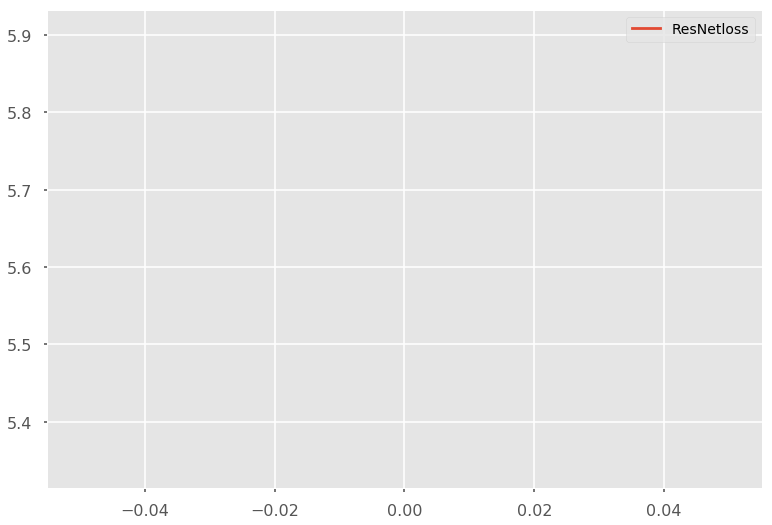

In [21]:
plt.plot(test_ppl.get_variable('loss'), label='ResNet' + 'loss')
plt.legend(fontsize=14)
plt.show()
global_acc.append(test_ppl.get_variable('loss'))
train_ppl.save_model(name, path=name)

In [22]:
np.mean(np.array((test_ppl.get_variable('loss')[-2:])))

IndexError: invalid index to scalar variable.

In [ ]:
import tensorflow as tf

In [ ]:
a_0 = np.array(np.arange(12)).reshape(4, 3)


In [ ]:
a = tf.placeholder(tf.int32, shape=[4, 3])
a1 = tf.reshape(a, [-1])

In [ ]:
sess = tf.Session()
d = sess.run(a1, feed_dict={a: a_0})
d

In [ ]:
b = tf.range(9)
c = tf.stack([b]*2, axis=1)
c = tf.reshape(c, [-1])
e = tf.constant((3, 3), dtype=tf.int32)
d = sess.run(e)
d

In [ ]:
pred_ppl = (
    (load_ppl << dset.test)
    .init_variable('loss', init_on_each_run=list)
    .import_model(name, train_ppl)
    .predict_model(name,
                   fetches=fetches_list,
                   feed_dict=saved_feed_dict,
                   save_to=saved_fetches, 
                   mode='a')
    )
    .init_model('dynamic', V('model'),
    name,
    config=config)
    .train_model(name,
     fetches=fetches_list,
     feed_dict=saved_feed_dict,
     save_to=saved_fetches, 
     mode='a')
    




All models was trained and reach almost the same accuracy ~ 0.9-1. Let's load one of them to plot the results.

In [ ]:
config['load'] = {'path':'./DenseNet121/'}

In [ ]:
%%time
model = DenseNet121(config=config)

Create pipeline to predict numbers on meters

In [ ]:
predict_ppl = (
    (load_ppl << dset.test)
    .init_variable('prediction', init_on_each_run=list)
    .init_variable('proba', init_on_each_run=list)
    .init_variable('accuracy', init_on_each_run=list)
    .import_model('DenseNet121', model)
    .predict_model('DenseNet121',
                   fetches=['output_labels',
                            'output_proba',
                            'output_accuracy'],
                   make_data=make_separate_digits,
                   save_to=[V('prediction'),
                            V('proba'),
                            V('accuracy')],
                   mode='a')
)

Plot prediction numbers

In [ ]:
batch_test = predict_ppl.next_batch(1, n_epochs=None, shuffle=True)

predict = predict_ppl.get_variable('prediction')[-1]
labels = batch_test.labels[-1]
sepcrop = batch_test.sepcrop[-1]
plt.title('Input image', fontsize=20)
plt.imshow(batch_test.images[-1])
plt.grid()
plt.show()

plt.title('Bounding box', fontsize=20)
plt.imshow(batch_test.cropped[-1])
plt.grid()

_, axis = plt.subplots(1, 8, figsize=(20, 10))
axis = axis.reshape(-1)
for i in range(8):
    axis[i].imshow(sepcrop[i])
    axis[i].set_title('Predict: {} \nAnswer: {}'.format(predict[i], labels[i]), fontsize=20)
    axis[i].grid()
    axis[i].axis('off')
plt.show()

Summing up in this example we learned:
* how to use meter batch
* categorize a number on water meter